# Recurrent Neural Networks

In [1]:
!cat ../book*

https://github.com/ageron/handson-ml


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from IPython.display import clear_output, Image, display, HTML
from tensorflow.examples.tutorials.mnist import input_data

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [3]:
# Where to save the figures
PROJECT_ROOT_DIR = ".."

In [4]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(
        PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

## Basic RNNs in TensorFlow
### Manual RNN

In [5]:
reset_graph()

n_inputs = 3
n_neurons = 5

In [6]:
X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

In [7]:
Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons], 
                                  dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons, n_neurons], 
                                  dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + b)

In [8]:
init = tf.global_variables_initializer()

In [9]:
# To run, we need to feed it inputs at both time steps:
# Mini batch:        inst0,     inst1,     inst2,     inst3
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

In [10]:
with tf.Session() as s:
    init.run()
    Y0_val, Y1_val = s.run([Y0, Y1], 
                           feed_dict={X0: X0_batch, X1: X1_batch})

In [11]:
print(Y0_val) # output at t=0
print(Y1_val) #           t=1

[[-0.0664006   0.96257669  0.68105787  0.70918542 -0.89821595]
 [ 0.9977755  -0.71978885 -0.99657625  0.9673925  -0.99989718]
 [ 0.99999774 -0.99898815 -0.99999893  0.99677622 -0.99999988]
 [ 1.         -1.         -1.         -0.99818915  0.99950868]]
[[-0.32789749  0.9033345   0.10371689 -0.97484881  0.023365  ]
 [-0.12210433  0.62805319  0.96718419 -0.99371207 -0.25839335]
 [-0.05078916  0.23659249  0.9691847  -0.99160379 -0.48125735]
 [ 0.40818208 -0.96800256 -0.13471517  0.97532058  0.38755944]]


## Static Unrolling through Time
Doing the same as above, using `static_rnn()`

In [12]:
# Same as above:
reset_graph()

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(
    basic_cell, [X0, X1], dtype=tf.float32)

Y0, Y1 = output_seqs

In [13]:
init = tf.global_variables_initializer()

In [14]:
with tf.Session() as s:
    init.run()
    Y0_val, Y1_val = s.run([Y0, Y1], 
                           feed_dict={X0: X0_batch, X1: X1_batch})

In [15]:
print(Y0_val) # output at t=0
print(Y1_val) #           t=1

[[-0.81393629 -0.43182844 -0.40150994  0.7043609   0.89640522]
 [-0.9915663  -0.95103657  0.19996507  0.98335052  0.99998963]
 [-0.99965042 -0.99683058  0.68092704  0.99918783  1.        ]
 [ 0.64988363 -0.16740513  0.99994725  0.81680971  0.99995029]]
[[-0.99959785 -0.99861717  0.98714638  0.99745673  1.        ]
 [-0.72472596  0.17925572  0.53362155 -0.65215266 -0.08035918]
 [-0.9957462  -0.96851194  0.9874723   0.84106421  0.99999976]
 [-0.72859728 -0.27958852  0.80567408 -0.20587993  0.9995411 ]]


In [16]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "b<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [17]:
show_graph(tf.get_default_graph())

### Packing Sequences

In [18]:
reset_graph()

n_steps = 2

In [19]:
perm = [1, 0, 2]
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs = tf.unstack(tf.transpose(X, perm=perm))

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(
    basic_cell, X_seqs, dtype=tf.float32)
outputs = tf.transpose(tf.stack(output_seqs), perm=perm)

In [20]:
init = tf.global_variables_initializer()

In [21]:
X_batch = np.array([
    # t=0       # t=1
    [[0, 1, 2], [9, 8, 7]], # instance 1
    [[3, 4, 5], [0, 0, 0]], #          2
    [[6, 7, 8], [6, 5, 4]], #          3
    [[9, 0, 1], [3, 2, 1]]  #          4
])

In [22]:
with tf.Session() as s:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [23]:
print(outputs_val)

[[[-0.91279727  0.83698678 -0.89277941  0.80308062 -0.5283336 ]
  [-1.          1.         -0.99794829  0.99985468 -0.99273592]]

 [[-0.99994391  0.99951613 -0.9946925   0.99030769 -0.94413054]
  [ 0.48733309  0.93389565 -0.31362072  0.88573611  0.2424476 ]]

 [[-1.          0.99999875 -0.99975014  0.99956584 -0.99466234]
  [-0.99994856  0.99999434 -0.96058172  0.99784708 -0.9099462 ]]

 [[-0.95972425  0.99951482  0.96938795 -0.969908   -0.67668229]
  [-0.84596014  0.96288228  0.96856463 -0.14777924 -0.9119423 ]]]


In [24]:
print(np.transpose(outputs_val, axes=perm)[1])

[[-1.          1.         -0.99794829  0.99985468 -0.99273592]
 [ 0.48733309  0.93389565 -0.31362072  0.88573611  0.2424476 ]
 [-0.99994856  0.99999434 -0.96058172  0.99784708 -0.9099462 ]
 [-0.84596014  0.96288228  0.96856463 -0.14777924 -0.9119423 ]]


## Dynamic Unrolling through Time

In [25]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

In [26]:
seq_length = tf.placeholder(tf.int32, [None])
outputs, states = tf.nn.dynamic_rnn(
    basic_cell, X, dtype=tf.float32, sequence_length=seq_length)

In [27]:
init = tf.global_variables_initializer()

In [28]:
seq_length_batch = np.array([2, 1, 2, 2])

In [29]:
with tf.Session() as s:
    init.run()
    outputs_val, states_val = s.run(
        [outputs, states], 
        feed_dict={X: X_batch, seq_length: seq_length_batch})

In [30]:
print(outputs_val)

[[[-0.68579948 -0.25901747 -0.80249101 -0.18141513 -0.37491536]
  [-0.99996698 -0.94501185  0.98072106 -0.9689762   0.99966913]]

 [[-0.99099374 -0.64768541 -0.67801034 -0.7415446   0.7719509 ]
  [ 0.          0.          0.          0.          0.        ]]

 [[-0.99978048 -0.85583007 -0.49696958 -0.93838578  0.98505187]
  [-0.99951065 -0.89148796  0.94170523 -0.38407657  0.97499216]]

 [[-0.02052618 -0.94588047  0.99935204  0.37283331  0.9998163 ]
  [-0.91052347  0.05769409  0.47446665 -0.44611037  0.89394671]]]


In [31]:
print(states_val)

[[-0.99996698 -0.94501185  0.98072106 -0.9689762   0.99966913]
 [-0.99099374 -0.64768541 -0.67801034 -0.7415446   0.7719509 ]
 [-0.99951065 -0.89148796  0.94170523 -0.38407657  0.97499216]
 [-0.91052347  0.05769409  0.47446665 -0.44611037  0.89394671]]


## Training a Sequence Classifier

In [32]:
reset_graph()

n_steps = 28
n_in = 28
n_neurons = 150
n_out = 10
ETA = 0.001

In [33]:
X = tf.placeholder(tf.float32, [None, n_steps, n_in])
y = tf.placeholder(tf.int32, [None])

In [34]:
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_out)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, 
                                                          logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=ETA)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [35]:
mnist = input_data.read_data_sets('/tmp/data/')
X_test = mnist.test.images.reshape((-1, n_steps, n_in))
y_test = mnist.test.labels

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [36]:
epochs = 100
batch_size = 150
train_acc = []
test_acc = []

with tf.Session() as s:
    init.run()
    
    for epoch in range(epochs):
        for i in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_in))
            s.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        train_acc.append(acc_train)
        test_acc.append(acc_test)
        if epoch % 10 == 0:
            print('%3d Train Acc: %.4f Test Acc %.4f' 
                  %(epoch, acc_train, acc_test))

  0 Train Acc: 0.9400 Test Acc 0.9308
 10 Train Acc: 0.9867 Test Acc 0.9742
 20 Train Acc: 0.9933 Test Acc 0.9785
 30 Train Acc: 0.9933 Test Acc 0.9777
 40 Train Acc: 0.9933 Test Acc 0.9708
 50 Train Acc: 0.9867 Test Acc 0.9758
 60 Train Acc: 1.0000 Test Acc 0.9764
 70 Train Acc: 0.9800 Test Acc 0.9797
 80 Train Acc: 0.9800 Test Acc 0.9800
 90 Train Acc: 0.9800 Test Acc 0.9787


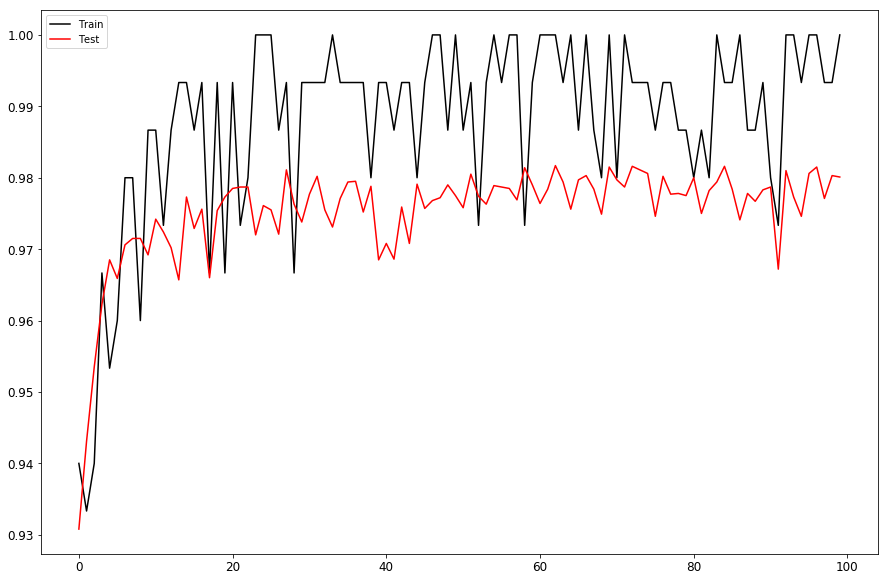

In [37]:
plt.plot(train_acc, 'k-', label='Train');
plt.plot(test_acc, 'r-', label='Test');
plt.legend(loc='best');

In [38]:
t_min, t_max = 0, 30
resolution = 0.1

In [39]:
def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t * 5)

In [40]:
def next_batch(batch_size, n_steps):
    t0 = (np.random.rand(batch_size, 1) * 
          (t_max - t_min - n_steps * resolution))
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return (ys[:, :-1].reshape(-1, n_steps, 1), 
            ys[:, 1:].reshape(-1, n_steps, 1))

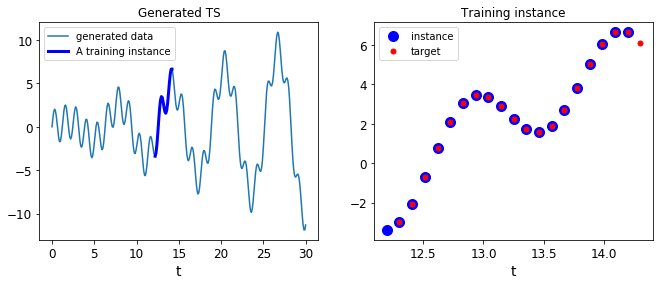

In [41]:
t = np.linspace(t_min, t_max, int((t_max - t_min)  / resolution))

n_steps = 20
t_instance = np.linspace(
    12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11, 4));
plt.subplot(121);
plt.title('Generated TS');
plt.plot(t, time_series(t), label='generated data');
plt.plot(t_instance[:-1], 
         time_series(t_instance[:-1]), 
         'b-', 
         linewidth=3, 
         label='A training instance');
plt.legend(loc='best')
plt.xlabel('t');

plt.subplot(122);
plt.title('Training instance');
plt.plot(t_instance[:-1], 
         time_series(t_instance[:-1]), 
         'bo', 
         markersize=10, 
         label='instance');
plt.plot(t_instance[1:], 
         time_series(t_instance[1:]), 
         'ro', 
         markersize=5, 
         label='target');
plt.legend(loc='best');
plt.xlabel('t');

In [42]:
X_batch, y_batch = next_batch(1, n_steps)

In [43]:
X_batch

array([[[-4.50341339],
        [-4.14236382],
        [-3.92870702],
        [-4.0488651 ],
        [-4.59566362],
        [-5.54426493],
        [-6.75703201],
        [-8.0161452 ],
        [-9.07599852],
        [-9.72255772],
        [-9.82515641],
        [-9.36805638],
        [-8.45405093],
        [-7.27923294],
        [-6.08510771],
        [-5.09977511],
        [-4.48258027],
        [-4.28578062],
        [-4.44260919],
        [-4.78464929]]])

In [44]:
y_batch # note, this is just X_batch shifted 1 place

array([[[-4.14236382],
        [-3.92870702],
        [-4.0488651 ],
        [-4.59566362],
        [-5.54426493],
        [-6.75703201],
        [-8.0161452 ],
        [-9.07599852],
        [-9.72255772],
        [-9.82515641],
        [-9.36805638],
        [-8.45405093],
        [-7.27923294],
        [-6.08510771],
        [-5.09977511],
        [-4.48258027],
        [-4.28578062],
        [-4.44260919],
        [-4.78464929],
        [-5.08425773]]])

## Using an `OutputProjectionWrapper` 
(simpler but less efficient)

Create the RNN. It will contain 100 recurrent neurons and we will unroll it over 20 time steps since each traiing instance will be 20 inputs long. Each input will contain only one feature (the value at that time). The targets are also sequences of 20 inputs, each containing a sigle value:

In [45]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

In [46]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [47]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, 
                                   activation=tf.nn.relu)
outputs, state = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

At each time step we now have an output vector of size 100. But what we actually want is a single output value at each time step. The simplest solution is to wrap the cell in an OutputProjectionWrapper.

In [48]:
# So....
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [49]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, 
                                activation=tf.nn.relu),
    output_size=n_outputs)

In [50]:
outputs, state = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [51]:
ETA = 0.001

mse = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(ETA)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [52]:
saver = tf.train.Saver()

In [53]:
iterations = 1500
batch_size = 50
mses = []

with tf.Session() as s:
    init.run()
    
    for i in range(iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        s.run(training_op, feed_dict={X: X_batch, y: y_batch})
        this_mse = mse.eval(feed_dict={X: X_batch, y: y_batch})
        mses.append(this_mse)
        
        if i % 100 == 0:
            print('%4d MSE: %.4f' %(i, this_mse))
            
    saver.save(s, './ts_mod1')

   0 MSE: 13.6543
 100 MSE: 0.5385
 200 MSE: 0.1685
 300 MSE: 0.0880
 400 MSE: 0.0633
 500 MSE: 0.0619
 600 MSE: 0.0559
 700 MSE: 0.0499
 800 MSE: 0.0518
 900 MSE: 0.0483
1000 MSE: 0.0484
1100 MSE: 0.0503
1200 MSE: 0.0412
1300 MSE: 0.0488
1400 MSE: 0.0426


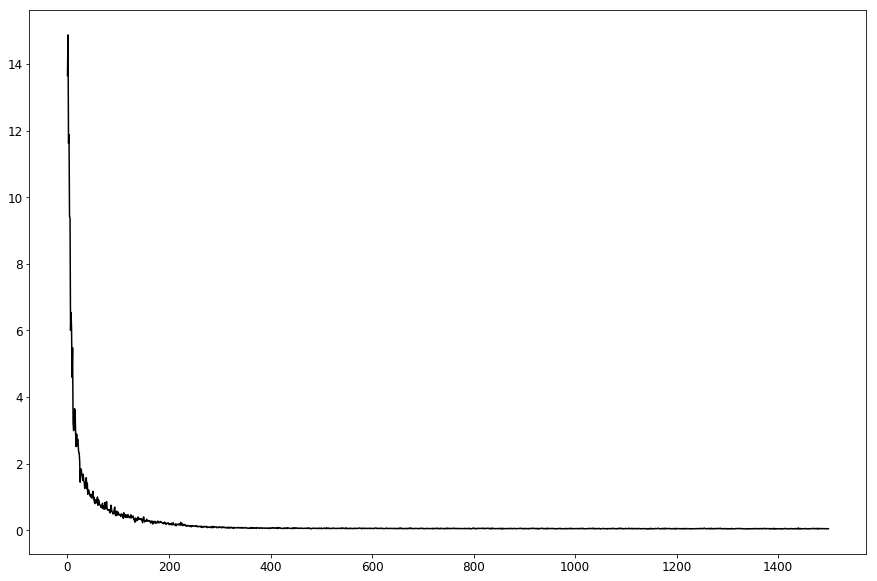

In [54]:
plt.plot(mses, 'k-');

In [55]:
with tf.Session() as s:
    saver.restore(s, './ts_mod1')
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, 
                                                         n_inputs)))
    y_pred = s.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./ts_mod1


In [56]:
y_pred

array([[[-3.42596436],
        [-2.48950148],
        [-1.1358937 ],
        [ 0.75142008],
        [ 2.19939661],
        [ 3.14104176],
        [ 3.54801917],
        [ 3.34113908],
        [ 2.82566142],
        [ 2.17759967],
        [ 1.65191436],
        [ 1.55619645],
        [ 1.94783175],
        [ 2.74632907],
        [ 3.89091802],
        [ 5.11678171],
        [ 6.13101864],
        [ 6.67043686],
        [ 6.62354612],
        [ 6.05428839]]], dtype=float32)

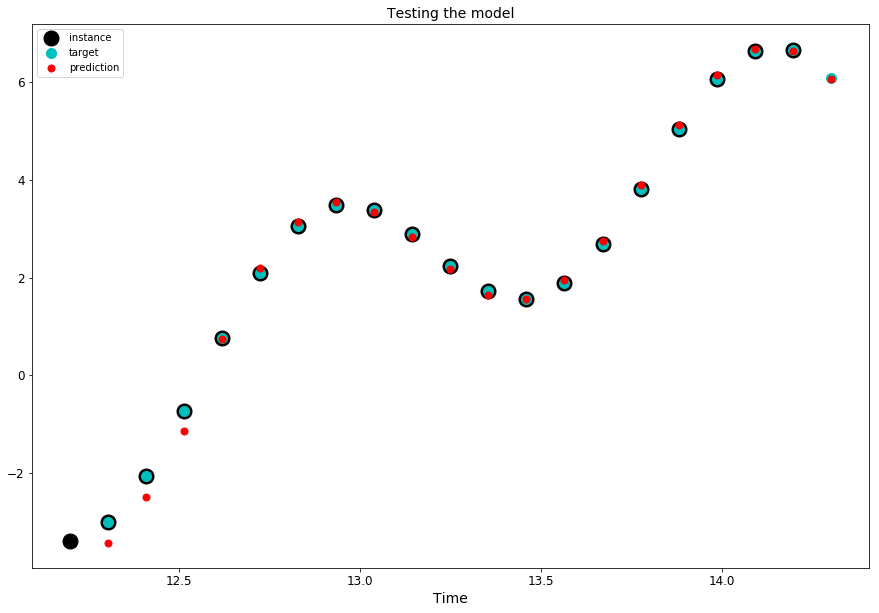

In [57]:
plt.title("Testing the model", fontsize=14);
plt.plot(t_instance[:-1], 
         time_series(t_instance[:-1]), 
         'ko', 
         markersize=15, 
         label="instance");
plt.plot(t_instance[1:], 
         time_series(t_instance[1:]), 
         'co', 
         markersize=10, 
         label="target");
plt.plot(t_instance[1:], 
         y_pred[0,:,0], 
         'ro',
         markersize=7, 
         label="prediction");
plt.legend(loc="upper left");
plt.xlabel("Time");

## Without an `OutputProjectionWrapper`
(Somewhat more complicated, but also more efficient)

In [58]:
reset_graph()

n_steps = 20
n_inputs = 1
n_outputs = 1
n_neurons = 100

ETA = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [59]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, 
                                   activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [60]:
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

In [61]:
mse = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(ETA)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [68]:
iterations = 1500
batch_size = 50
mses = []

with tf.Session() as s:
    init.run()
    
    for i in range(iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        s.run(training_op, feed_dict={X: X_batch, y: y_batch})
        this_mse = mse.eval(feed_dict={X: X_batch, y: y_batch})
        mses.append(this_mse)
        
        if i % 100 == 0:
            print('%4d MSE: %.4f' %(i, this_mse))
            
    X_new = time_series(np.array(
        t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = s.run(outputs, feed_dict={X: X_new})
    
    saver.save(s, './ts_mod2')

   0 MSE: 16.1546
 100 MSE: 0.4979
 200 MSE: 0.1990
 300 MSE: 0.0763
 400 MSE: 0.0690
 500 MSE: 0.0531
 600 MSE: 0.0437
 700 MSE: 0.0461
 800 MSE: 0.0555
 900 MSE: 0.0445
1000 MSE: 0.0426
1100 MSE: 0.0388
1200 MSE: 0.0410
1300 MSE: 0.0379
1400 MSE: 0.0343


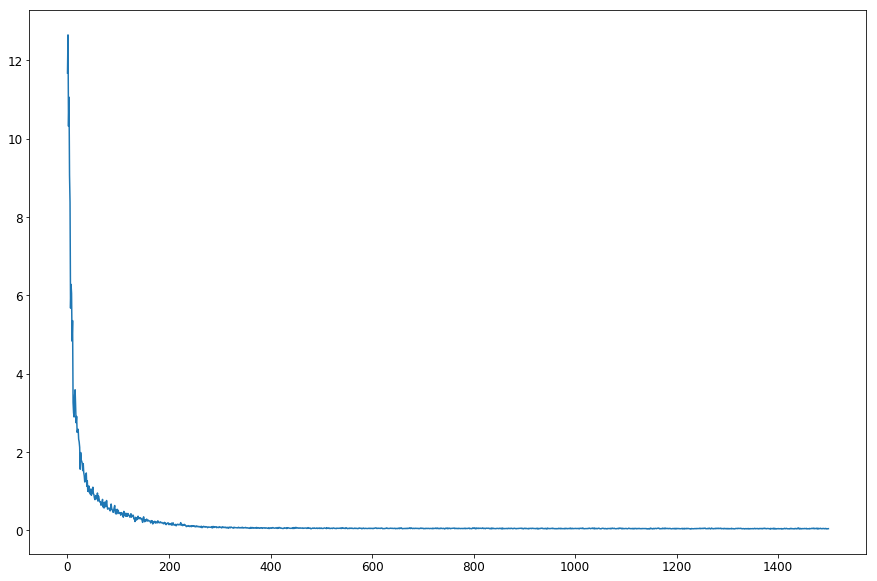

In [63]:
plt.plot(mses);

In [64]:
y_pred

array([[[-3.42077947],
        [-2.47134852],
        [-1.14368439],
        [ 0.75839251],
        [ 2.15983796],
        [ 3.11996722],
        [ 3.52640414],
        [ 3.43011165],
        [ 2.8376286 ],
        [ 2.18515253],
        [ 1.6659894 ],
        [ 1.54036307],
        [ 1.89834416],
        [ 2.73356843],
        [ 3.9192028 ],
        [ 5.16150093],
        [ 6.10899305],
        [ 6.66055822],
        [ 6.65600348],
        [ 6.09106874]]], dtype=float32)

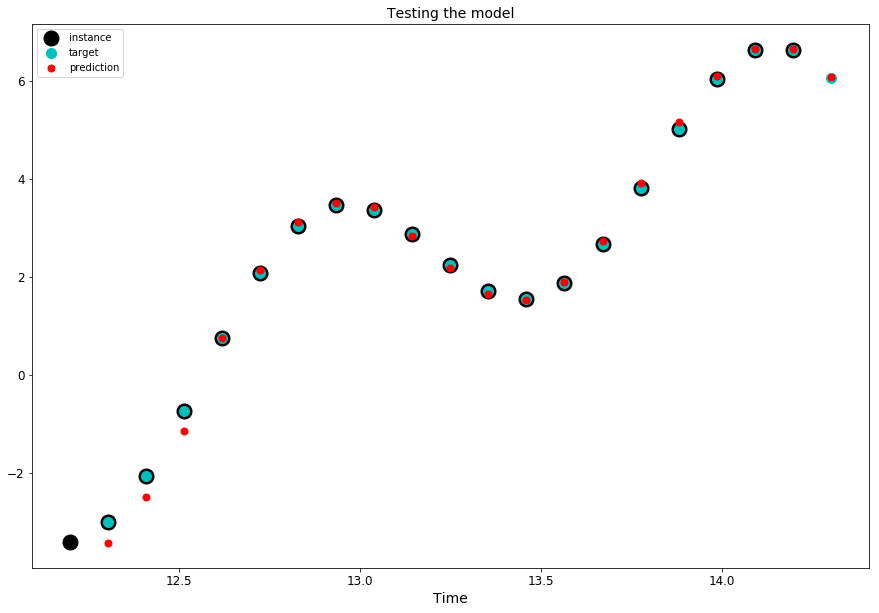

In [65]:
plt.title("Testing the model", fontsize=14);
plt.plot(t_instance[:-1], 
         time_series(t_instance[:-1]), 
         'ko', 
         markersize=15, 
         label="instance");
plt.plot(t_instance[1:], 
         time_series(t_instance[1:]), 
         'co', 
         markersize=10, 
         label="target");
plt.plot(t_instance[1:], 
         y_pred[0,:,0], 
         'ro',
         markersize=7, 
         label="prediction");
plt.legend(loc="upper left");
plt.xlabel("Time");

# Generative RNN (Forecasting)

In [73]:
with tf.Session() as s:
    saver.restore(s, './ts_mod2')
    n_ahead = 500
    seq = [0.] * n_steps
    for i in range(n_ahead):
        X_batch = np.array(seq[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = s.run(outputs, feed_dict={X: X_batch})
        seq.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./ts_mod2


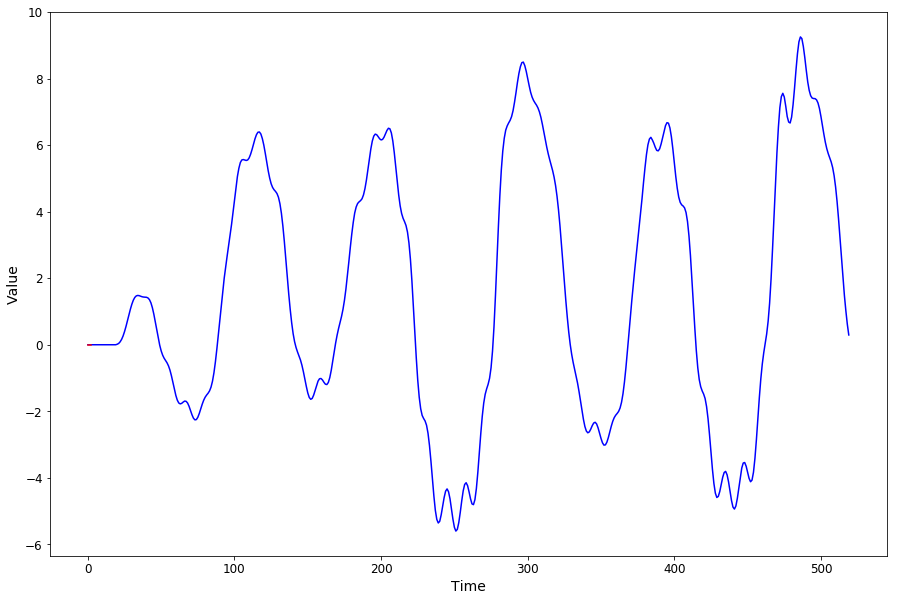

In [74]:
plt.plot(np.arange(len(seq)), seq, 'b-');
plt.plot(t[:n_steps], seq[:n_steps], 'r-');
plt.xlabel('Time');
plt.ylabel('Value');

In [75]:
with tf.Session() as s:
    saver.restore(s, './ts_mod2')
    
    seq1 = [0. for i in range(n_steps)]
    for i in range(len(t) - n_steps):
        X_batch = np.array(seq1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = s.run(outputs, feed_dict={X: X_batch})
        seq1.append(y_pred[0, -1, 0])
        
    seq2 = [time_series(i * resolution + t_min + (t_max - t_min / 3))
            for i in range(n_steps)]
    for i in range(len(t) - n_steps):
        X_batch = np.array(seq2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = s.run(outputs, feed_dict={X: X_batch})
        seq2.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./ts_mod2


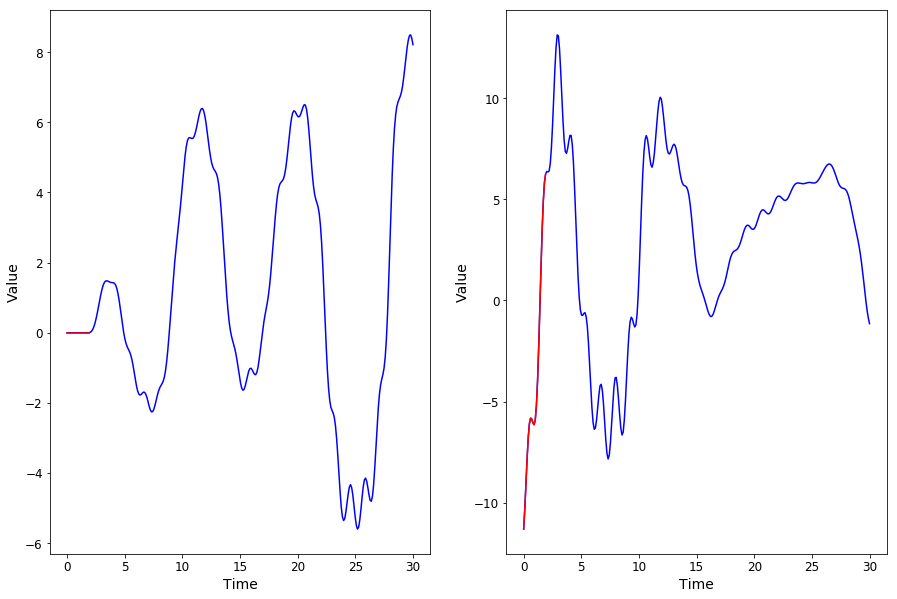

In [76]:
plt.subplot(121);
plt.plot(t, seq1, 'b-');
plt.plot(t[:n_steps], seq1[:n_steps], 'r-');
plt.xlabel('Time');
plt.ylabel('Value');

plt.subplot(122);
plt.plot(t, seq2, 'b-');
plt.plot(t[:n_steps], seq2[:n_steps], 'r-');
plt.xlabel('Time');
plt.ylabel('Value');

# Deep RNNs
### MultiRNNCell

In [95]:
reset_graph()

n_inputs = 2
n_steps = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

In [96]:
n_neurons = 100
n_layers = 3

# NOTE: it is not necessary that all units have the same number of neurons,
# this is just for simplicity here
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
          for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [97]:
init = tf.global_variables_initializer()

In [98]:
X_batch = np.random.rand(2, n_steps, n_inputs)

In [99]:
with tf.Session() as s:
    init.run()
    outputs_val, states_val = s.run([outputs, states], 
                                   feed_dict={X: X_batch})

In [100]:
outputs_val.shape

(2, 5, 100)

# Distributing a Deep RNN Across Multiple GPUs
and
# Applying Dropout
(Omitted here, see....)

In [103]:
!cat ../bookGithubRepoURL.txt

https://github.com/ageron/handson-ml
